In [1]:
#주의 사항
#원본 코드 그대로 실행하면 openai api를 가져오는 과정에서 proxie 뭔 에러가 나옴 버전이 달라지면서 오류가 발생했다고 생각함
#따라서 openai 버전만 올려줌
!pip install pinecone-client==3.2.2 sentence-transformers==2.7.0 datasets==2.19.0 faiss-cpu==1.8.0 transformers==4.40.1 openai==1.55.3 llama-index==0.10.34 llama-index-vector-stores-pinecone==0.1.6  -qqq

## 예제 12.1 실습 데이터 다운로드

In [2]:
!wget ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
!tar -xf sift.tar.gz
!mkdir data/sift1M -p
!mv sift/* data/sift1M

--2025-01-15 07:38:31--  ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
           => ‘sift.tar.gz’
Resolving ftp.irisa.fr (ftp.irisa.fr)... 131.254.254.45, 2001:660:7303:254::45
Connecting to ftp.irisa.fr (ftp.irisa.fr)|131.254.254.45|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /local/texmex/corpus ... done.
==> SIZE sift.tar.gz ... 168280445
==> PASV ... done.    ==> RETR sift.tar.gz ... done.
Length: 168280445 (160M) (unauthoritative)

sift.tar.gz         100%[===================>] 160.48M  21.7MB/s    in 8.6s    

2025-01-15 07:38:42 (18.7 MB/s) - ‘sift.tar.gz’ saved [168280445]



## 예제 12.2 실습 데이터 불러오기

In [3]:
import psutil

def get_memory_usage_mb():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)

In [4]:
import time
import faiss
from faiss.contrib.datasets import DatasetSIFT1M

ds = DatasetSIFT1M()

xq = ds.get_queries()
xb = ds.get_database()
gt = ds.get_groundtruth()

## 예제 12.3 데이터가 늘어날 때 색인/검색 시간, 메모리 사용량 변화

In [5]:
k=1
d = xq.shape[1]
nq = 1000 #검색할 데이터 수
xq = xq[:nq] #입력에서 1000개만 가져와서 사용

for i in range(1, 10, 2):
    start_memory = get_memory_usage_mb()
    start_indexing = time.time()
    index = faiss.IndexFlatL2(d)
    index.add(xb[:(i+1)*100000])
    end_indexing = time.time()
    end_memory = get_memory_usage_mb()

    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()
    print(f"데이터 {(i+1)*100000}개:")
    print(f"색인: {(end_indexing - start_indexing) * 1000 :.3f} ms ({end_memory - start_memory:.3f} MB) 검색: {(t1 - t0) * 1000 / nq :.3f} ms")

데이터 200000개:
색인: 100.611 ms (98.121 MB) 검색: 2.557 ms
데이터 400000개:
색인: 221.507 ms (97.516 MB) 검색: 7.736 ms
데이터 600000개:
색인: 504.149 ms (97.621 MB) 검색: 9.670 ms
데이터 800000개:
색인: 661.510 ms (97.613 MB) 검색: 10.402 ms
데이터 1000000개:
색인: 637.577 ms (97.668 MB) 검색: 8.326 ms


## 예제 12.4 파라미터 m의 변경에 따른 성능 확인

In [6]:
import numpy as np
#HNSW 방식 시험 코드
k=1
d = xq.shape[1]
nq = 1000
xq = xq[:nq]

for m in [8, 16, 32, 64]: #연결되는 간선의 수 많을수록 촘촘하지만 시간이 걸림
    index = faiss.IndexHNSWFlat(d, m)
    time.sleep(3)
    start_memory = get_memory_usage_mb()
    start_index = time.time()
    index.add(xb)
    end_memory = get_memory_usage_mb()
    end_index = time.time()
    print(f"M: {m} - 색인 시간: {end_index - start_index} s, 메모리 사용량: {end_memory - start_memory} MB")

    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()

    recall_at_1 = np.equal(I, gt[:nq, :1]).sum() / float(nq)
    print(f"{(t1 - t0) * 1000.0 / nq:.3f} ms per query, R@1 {recall_at_1:.3f}")

    #결과를 보면 KNN보다 시간이 압도적으로 빠른데 정확도는 비슷함

M: 8 - 색인 시간: 91.90643811225891 s, 메모리 사용량: 572.1953125 MB
0.034 ms per query, R@1 0.684
M: 16 - 색인 시간: 100.85226440429688 s, 메모리 사용량: 624.56640625 MB
0.091 ms per query, R@1 0.789
M: 32 - 색인 시간: 193.1684229373932 s, 메모리 사용량: 736.83203125 MB
0.134 ms per query, R@1 0.904
M: 64 - 색인 시간: 253.39973783493042 s, 메모리 사용량: 1011.95703125 MB
0.118 ms per query, R@1 0.933


## 예제 12.5 ef_construction을 변화시킬 때 성능 확인

In [7]:
#ef_construction란 M개의 가장 가까운 벡터를 선택할 후보군을 저장한 dynamic queue 개념 크기가 크면 더 많은 후보를 탐색하기 때문에 성능이 좋아진다

d = xq.shape[1]
nq = 1000
xq = xq[:nq]

for ef_construction in [40, 80, 160, 320]:
    index = faiss.IndexHNSWFlat(d, 32)
    index.hnsw.efConstruction = ef_construction
    time.sleep(3)
    start_memory = get_memory_usage_mb()
    start_index = time.time()
    index.add(xb)
    end_memory = get_memory_usage_mb()
    end_index = time.time()
    print(f"efConstruction: {ef_construction} - 색인 시간: {end_index - start_index} s, 메모리 사용량: {end_memory - start_memory} MB")

    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()

    recall_at_1 = np.equal(I, gt[:nq, :1]).sum() / float(nq)
    print(f"{(t1 - t0) * 1000.0 / nq:.3f} ms per query, R@1 {recall_at_1:.3f}")

efConstruction: 40 - 색인 시간: 195.64212584495544 s, 메모리 사용량: 799.48046875 MB
0.083 ms per query, R@1 0.895
efConstruction: 80 - 색인 시간: 240.48120617866516 s, 메모리 사용량: 799.421875 MB
0.065 ms per query, R@1 0.861
efConstruction: 160 - 색인 시간: 479.11301493644714 s, 메모리 사용량: 799.421875 MB
0.072 ms per query, R@1 0.906
efConstruction: 320 - 색인 시간: 935.0602014064789 s, 메모리 사용량: 799.6796875 MB
0.078 ms per query, R@1 0.918


## 예제 12.6 ef_search 변경에 따른 성능 확인

In [8]:
for ef_search in [16, 32, 64, 128]:
    index.hnsw.efSearch = ef_search
    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()

    recall_at_1 = np.equal(I, gt[:nq, :1]).sum() / float(nq)
    print(f"{(t1 - t0) * 1000.0 / nq:.3f} ms per query, R@1 {recall_at_1:.3f}")

0.079 ms per query, R@1 0.918
0.131 ms per query, R@1 0.971
0.222 ms per query, R@1 0.986
0.411 ms per query, R@1 0.992


요약 및 설정 팁  
ef_construction: “그래프 만들 때 노드 연결을 얼마나 풍부하게 할까?”  
그래프 자체의 품질을 결정  
높을수록 구축 시간/메모리는 증가하지만 검색 품질이 좋아짐  
낮을수록 구축은 빠르고 가벼우나 검색 품질이 떨어질 수 있음  

ef_search: “검색할 때 후보를 얼마나 많이 볼까?”  
검색 결과의 정확도와 검색 속도를 직접적으로 결정  
높을수록 정확도 개선, 하지만 검색 시간이 길어짐  
낮을수록 검색은 빠르지만 정확도가 떨어질 수 있음  

## 예제 12.7 파인콘 계정 연결 및 인덱스 생성

In [10]:
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata

pinecone_api_key = userdata.get('pine')
pc = Pinecone(api_key=pinecone_api_key)

pc.create_index("llm-book", spec=ServerlessSpec("aws", "us-east-1"), dimension=768)
index = pc.Index('llm-book')

## 예제 12.8 임베딩 생성

In [11]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
# 임베딩 모델 불러오기
sentence_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
# 데이터셋 불러오기
klue_dp_train = load_dataset('klue', 'dp', split='train[:100]')

embeddings = sentence_model.encode(klue_dp_train['sentence'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/336k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/967k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## 예제 12.9 파인콘 입력을 위한 데이터 형태 변경

In [12]:
# 파이썬 기본 데이터 타입으로 변경
embeddings = embeddings.tolist()
# {"id": 문서 ID(str), "values": 벡터 임베딩(List[float]), "metadata": 메타 데이터(dict) ) 형태로 데이터 준비
insert_data = []
for idx, (embedding, text) in enumerate(zip(embeddings, klue_dp_train['sentence'])):
  insert_data.append({"id": str(idx), "values": embedding, "metadata": {'text': text}})

## 예제 12.10 임베딩 데이터를 인덱스에 저장

In [13]:
upsert_response = index.upsert(vectors = insert_data, namespace='llm-book-sub')

## 예제 12.11 인덱스 검색하기

In [14]:
query_response = index.query(
    namespace='llm-book-sub', # 검색할 네임스페이스
    top_k=10, # 몇 개의 결과를 반환할지
    include_values=True, # 벡터 임베딩 반환 여부
    include_metadata=True, # 메타 데이터 반환 여부
    vector=embeddings[0] # 검색할 벡터 임베딩
)
query_response

{'matches': [], 'namespace': 'llm-book-sub', 'usage': {'read_units': 1}}

## 예제 12.12 파인콘에서 문서 수정 및 삭제

In [ ]:
new_text = '변경할 새로운 텍스트'
new_embedding = sentence_model.encode(new_text).tolist()
# 업데이트
update_response = index.update(
    id= '기존_문서_id',
    values=new_embedding,
    set_metadata={'text': new_text},
    namespace='llm-book-sub'
)

# 삭제
delete_response = index.delete(ids=['기존_문서_id'], namespace='llm-book-sub')

## 예제 12.13 라마인덱스에서 다른 벡터 데이터베이스 사용

In [ ]:
# 파인콘 기본 설정
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=pinecone_api_key)
pc.create_index(
    "quickstart", dimension=1536, metric="euclidean", spec=ServerlessSpec("aws", "us-east-1")
)
pinecone_index = pc.Index("quickstart")

# 라마인덱스에 파인콘 인덱스 연결
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.pinecone import PineconeVectorStore
from llama_index.core import StorageContext

vector_store = PineconeVectorStore(pinecone_index=pinecone_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

## 예제 12.14 실습 데이터셋 다운로드

In [5]:
from datasets import load_dataset

dataset = load_dataset("poloclub/diffusiondb", "2m_first_1k", split='train')

example_index = 867
original_image = dataset[example_index]['image']
original_prompt = dataset[example_index]['prompt']
print(original_prompt)

# cute fluffy baby cat rabbit lion hybrid mixed creature character concept,
# with long flowing mane blowing in the wind, long peacock feather tail,
# wearing headdress of tribal peacock feathers and flowers, detailed painting,
# renaissance, 4 k

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for poloclub/diffusiondb contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/poloclub/diffusiondb
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
 

cute fluffy baby cat rabbit lion hybrid mixed creature character concept, with long flowing mane blowing in the wind, long peacock feather tail, wearing headdress of tribal peacock feathers and flowers, detailed painting, renaissance, 4 k 


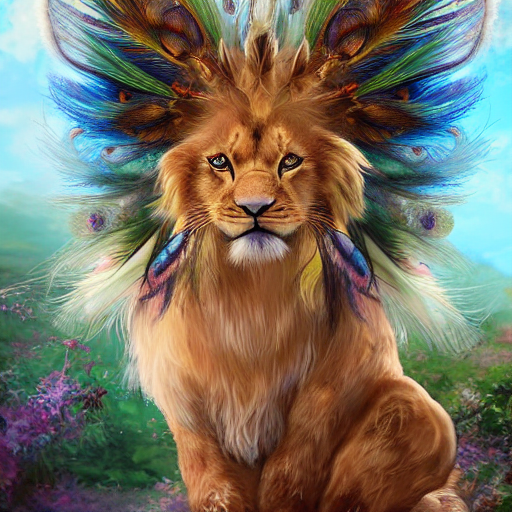

In [21]:
original_image

## 예제 12.15 GPT-4o 요청에 사용할 함수

In [6]:
import requests
import base64
from io import BytesIO

def make_base64(image):
  buffered = BytesIO()
  image.save(buffered, format="JPEG")
  img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
  return img_str

def generate_description_from_image_gpt4(prompt, image64):
  headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {client.api_key}"
  }
  payload = {
      "model": "gpt-4o",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{image64}"
              }
            }
          ]
        }
      ],
      "max_tokens": 300
  }
  response_oai = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  result = response_oai.json()['choices'][0]['message']['content']
  return result

## 예제 12.16 이미지 설명 생성

In [16]:
image_base64 = make_base64(original_image)
described_result = generate_description_from_image_gpt4("Describe provided image", image_base64)
described_result
# The image depicts a digitally created, fantastical creature that combines features of different animals. It has the body and face of a lion, with a rich, golden mane that transitions into an array of vibrant, peacock-like feathers. The feathers themselves are full of brilliant colors, primarily blues and greens, with "eyes" that mimic the look of a peacock's plumage. The creature is sitting down and facing forward with a calm and majestic expression.
# The creature is set against a picturesque backdrop that resembles a lush, blooming meadow or garden, with rolling green hills in the distance and a blue sky above. The colors are rich and the composition is balanced, emphasizing the surreal and regal aspect of the creature. It's an imaginative piece that blends the natural elements of these animals in a mystical way.
# 이 이미지는 다양한 동물의 특징을 결합한 디지털로 창조된 환상적인 생물을 묘사합니다. 이 동물은 사자의 몸과 얼굴을 하고 있으며, 풍성한 황금빛 갈기가 공작새와 같은 생생한 깃털로 변합니다. 깃털은 주로 파란색과 녹색의 화려한 색상으로 가득하며, 공작의 깃털을 닮은 '눈'이 있습니다. 이 생물은 차분하고 장엄한 표정으로 앉아서 정면을 바라보고 있습니다.
# 이 생물은 무성하고 꽃이 만발한 초원이나 정원을 연상시키는 그림 같은 배경을 배경으로 멀리 푸른 언덕이 펼쳐져 있고 위로는 푸른 하늘이 펼쳐져 있습니다. 색상이 풍부하고 구도가 균형 잡혀 있어 초현실적이고 당당한 생물의 모습을 강조합니다. 동물의 자연적 요소를 신비로운 방식으로 혼합한 상상력이 돋보이는 작품입니다.

"The image depicts a lion with an imaginative twist. The lion's mane is combined with vibrant and colorful peacock feathers, creating a striking and fantastical appearance. The background features a serene natural setting with greenery and flowers, complementing the majestic and artistic portrayal of the lion."

## 예제 12.17 클라이언트 준비

In [4]:
import os
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata
pinecone_api_key = userdata.get('pine') # '자신의 파인콘 API 키 입력'
openai_api_key = userdata.get('op')

pc = Pinecone(api_key=pinecone_api_key)
os.environ["OPENAI_API_KEY"]=openai_api_key
client = OpenAI()

## 예제 12.18 인덱스 생성

In [7]:
print(pc.list_indexes())

index_name = "llm-multimodal"
try:
  pc.create_index(
    name=index_name,
    dimension=512,
    metric="cosine",
    spec=ServerlessSpec(
      "aws", "us-east-1"
    )
  )
  print(pc.list_indexes())
except:
  print("Index already exists")
index = pc.Index(index_name)
#한가지 이상한게 차원을 512로 잡았는데 밑에 결과는 왜 768일까??
#파인콘 홈페이지 들어가서 db확인해도 512로 나오는데

{'indexes': [{'dimension': 768,
              'host': 'llm-book-wd6txeg.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'llm-book',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'dimension': 1536,
              'host': 'quickstart-wd6txeg.svc.aped-4627-b74a.pinecone.io',
              'metric': 'euclidean',
              'name': 'quickstart',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}
{'indexes': [{'dimension': 768,
              'host': 'llm-book-wd6txeg.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'llm-book',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'dimension': 512,
              'host': '

## 예제 12.19 프롬프트 텍스트를 텍스트 임베딩 모델을 활용해 임베딩 벡터로 변환

In [22]:
import torch
from tqdm.auto import trange
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, CLIPTextModelWithProjection

device = "cuda" if torch.cuda.is_available() else "cpu"

text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
#여기서 사용한 openai의 CLIP 모델은 이미지와 그 이미지의 캡션으로 학습해 이미지와 텍스트를 동일한 벡터 공간상에 임베딩할 수 있도록 학습시킨 모델이다.
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

tokens = tokenizer(dataset['prompt'], padding=True, return_tensors="pt", truncation=True)
batch_size = 16
text_embs = []
for start_idx in trange(0, len(dataset), batch_size):
    with torch.no_grad():
        outputs = text_model(input_ids = tokens['input_ids'][start_idx:start_idx+batch_size],
                        attention_mask = tokens['attention_mask'][start_idx:start_idx+batch_size])
        text_emb_tmp = outputs.text_embeds
    text_embs.append(text_emb_tmp)
text_embs = torch.cat(text_embs, dim=0)
text_embs.shape # (1000, 512)

  0%|          | 0/63 [00:00<?, ?it/s]

torch.Size([1000, 512])

## 예제 12.20 텍스트 임베딩 벡터를 파인콘 인덱스에 저장

In [9]:
input_data = []
for id_int, emb, prompt in zip(range(0, len(dataset)), text_embs.tolist(), dataset['prompt']):
  input_data.append(
      {
          "id": str(id_int),
          "values": emb,
          "metadata": {
              "prompt": prompt
          }
      }
  )

index.upsert(
  vectors=input_data
)

{'upserted_count': 1000}

## 예제 12.21 이미지 임베딩을 사용한 유사 프롬프트 검색

In [12]:
from transformers import AutoProcessor, CLIPVisionModelWithProjection

vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")#모델이 필요한 형태에 맞춰 데이터를 변환해 주는 ‘사전 처리기(Processor)’ 역할을 한다고 보시면 됩니다.

inputs = processor(images=original_image, return_tensors="pt") #이미지를

outputs = vision_model(**inputs)
image_embeds = outputs.image_embeds

search_results = index.query(
  vector=image_embeds[0].tolist(),
  top_k=3,
  include_values=False,
  include_metadata=True
)
searched_idx = int(search_results['matches'][0]['id'])

## 예제 12.22 이미지 임베딩을 사용해 검색한 유사 프롬프트 확인

In [13]:
search_results

# {'matches': [{'id': '918',
#               'metadata': {'prompt': 'cute fluffy bunny cat lion hybrid mixed '
#                                      'creature character concept, with long '
#                                      'flowing mane blowing in the wind, long '
#                                      'peacock feather tail, wearing headdress '
#                                      'of tribal peacock feathers and flowers, '
#                                      'detailed painting, renaissance, 4 k '},
#               'score': 0.372838408,
#               'values': []},
#              {'id': '867',
#               'metadata': {'prompt': 'cute fluffy baby cat rabbit lion hybrid '
#                                      'mixed creature character concept, with '
#                                      'long flowing mane blowing in the wind, '
#                                      'long peacock feather tail, wearing '
#                                      'headdress of tribal peacock feathers and '
#                                      'flowers, detailed painting, renaissance, '
#                                      '4 k '},
#               'score': 0.371655703,
#               'values': []},
# ...

{'matches': [{'id': '918',
              'metadata': {'prompt': 'cute fluffy bunny cat lion hybrid mixed '
                                     'creature character concept, with long '
                                     'flowing mane blowing in the wind, long '
                                     'peacock feather tail, wearing headdress '
                                     'of tribal peacock feathers and flowers, '
                                     'detailed painting, renaissance, 4 k '},
              'score': 0.37472105,
              'values': []},
             {'id': '817',
              'metadata': {'prompt': 'cute fluffy baby cat lion hybrid mixed '
                                     'creature character concept, with long '
                                     'flowing mane blowing in the wind, long '
                                     'peacock feather tail, wearing headdress '
                                     'of tribal peacock feathers and flowers, '
           

## 예제 12.23 프롬프트로 이미지를 생성하고 저장하는 함수 정의

In [14]:
from PIL import Image

def generate_image_dalle3(prompt):
  response_oai = client.images.generate(
    model="dall-e-3",
    prompt=str(prompt),
    size="1024x1024",
    quality="standard",
    n=1,
  )
  result = response_oai.data[0].url
  return result

def get_generated_image(image_url):
  generated_image = requests.get(image_url).content
  image_filename = 'gen_img.png'
  with open(image_filename, "wb") as image_file:
      image_file.write(generated_image)
  return Image.open(image_filename)

## 예제 12.24 준비한 3개의 프롬프트로 이미지 생성

In [17]:
# GPT-4o가 만든 프롬프트로 이미지 생성
gpt_described_image_url = generate_image_dalle3(described_result)
gpt4o_prompt_image = get_generated_image(gpt_described_image_url)
gpt4o_prompt_image

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# 원본 프롬프트로 이미지 생성
original_prompt_image_url = generate_image_dalle3(original_prompt)
original_prompt_image = get_generated_image(original_prompt_image_url)
original_prompt_image

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# 이미지 임베딩으로 검색한 유사 프롬프트로 이미지 생성
searched_prompt_image_url = generate_image_dalle3(dataset[searched_idx]['prompt'])
searched_prompt_image = get_generated_image(searched_prompt_image_url)
searched_prompt_image

Output hidden; open in https://colab.research.google.com to view.

## 예제 12.25 이미지 출력

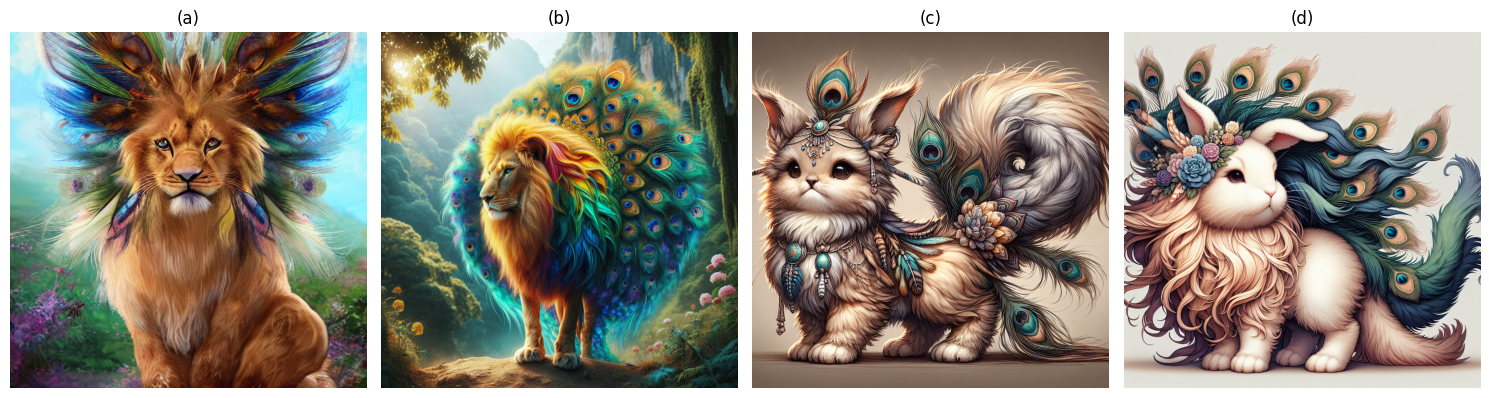

In [20]:
import matplotlib.pyplot as plt

images = [original_image, gpt4o_prompt_image, original_prompt_image, searched_prompt_image]
titles = ['(a)', '(b)', '(c)', '(d)']

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()